# The ARI Model of Time Series
- An ARI model using lag number 7 and differenced once
- Trained and tested on a 63+18 dataset, step = 7
    - one model per trial instead of Walk Forward
- Evaluated with average RMSE, MAE, MAPE

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("CACases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
df.head()

,date,Los Angeles,San Diego,San Francisco,Santa Barbara,Fresno,Sacramento,Ventura,Riverside
0,2020-02-01,13.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,2020-02-02,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-02-03,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-02-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# counties we are interested in
counties = ["Los Angeles", "San Diego", "San Francisco", "Santa Barbara",\
            "Fresno", "Sacramento", "Ventura", "Riverside"]

# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [5]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each county
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for county in counties:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[county].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[county] = temp

In [6]:
df1.set_index("date", inplace=True)

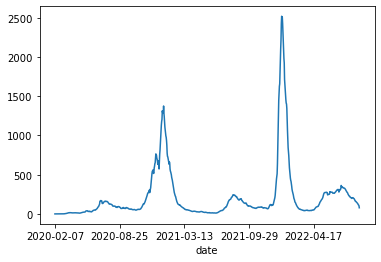

In [7]:
df1["Ventura"].plot()
plt.show()

In [8]:
# input: original dataset, county we want
# output: all data, sorted by date, of that county
def extract(dataset, county):
    # select data only from the input county
    temp = dataset.to_dict()[county]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

# Differencing

In [9]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

# Data Rescaling

In [10]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

# Data Reshaping

In [11]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg  # output: a data frame
# transform series into train and test sets for supervised learning
def prepare_data(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for test_scaled
    # test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = [row[0][0] for row in train_scaled]
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list, train: list, test: np array

## Evaluation with RMSE, MAE, MAPE

In [12]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(truth, forecasts):
    rmse = np.sqrt(mean_squared_error(truth, forecasts))
    mae = mean_absolute_error(truth, forecasts)
    truth = np.array(truth)
    forecasts = np.array(forecasts)
    mape = mean_absolute_percentage_error(truth, forecasts)*100
    return rmse, mae, mape

In [13]:
# evaluate the model
def make_forecasts(model, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)  # (train_size+n_lag-1):-1
    for i in range(test_size):
        X = test[i, 0:n_lag]  # X_test, will not use y_test
        # make forecast
        forecast = model.params[0]  # initlialize with coefficient
        for j in range(n_lag):
            forecast += model.params[j+1] * X[j]  # forecast = a0 + a_i * X_i for i = 1,...,7
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast, diff)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# Training Model

### AutoRegression
- assume observations from previous time steps are useful to predict values at latter time steps
    - true for Time Series
- choose a proper lag
    - use lag as variable
    - if all lag variables show no correlation with output, then the time series problem could be not predictable
    - Use the same lag number for AR, LSTM, and combined, for comparison

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$
where $p$ is the lag number, p = 7

# A Single Trial as Demo

In [14]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size

# Check Stationarity

In [15]:
county = "Los Angeles"

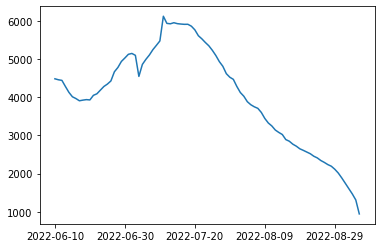

In [16]:
# Demo: on Los Angeles
s = extract(df1, county)
raw_value = s[-(train_size+test_size+n_lag):]
raw_value.plot()
plt.show()

In [17]:
X = raw_value.values
split = int(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4932.366883, mean2=3138.613636
variance1=512416.535619, variance2=1247665.984768


## Augmented Dickey-Fuller Test

Null Hypothesis: not stationary

In [18]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))## Augmented Dickey-Fuller Test

ADF Statistic: 0.460336
p-value: 0.983616
Critical Values:
	1%: -3.516
	5%: -2.899
	10%: -2.587


## Kwiatkowski Phillips Schmidt Shin (KPSS) Test

Null Hypothesis: stationary

In [19]:
result_kpss = kpss(X,regression="c")
print('KPSS Statistic: %f' %result_kpss[0])
print('p-value: %f' %result_kpss[1])
print('Critical values:')
for key, value in result_kpss[3].items():
     print('\t%s: %.3f' %(key, value))

KPSS Statistic: 0.494570
p-value: 0.042890
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


The test statistics is greater than the critical value, reject null hypothesis: the data is non-stationary

In [20]:
# diff = X  
diff = difference(X, 1)

In [21]:
## ADF
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
## KPSS
result_kpss = kpss(diff,regression="c")
print('KPSS Statistic: %f' %result_kpss[0])
print('p-value: %f' %result_kpss[1])
print('Critical values:')
for key, value in result_kpss[3].items():
     print('\t%s: %.3f' %(key, value))

ADF Statistic: -1.515846
p-value: 0.525658
Critical Values:
	1%: -3.516
	5%: -2.899
	10%: -2.587
KPSS Statistic: 0.416665
p-value: 0.069972
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


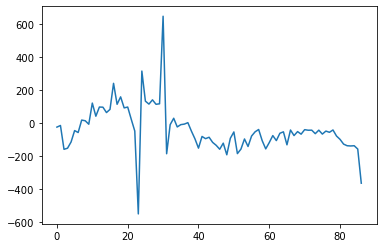

In [22]:
plt.plot(diff)
plt.show()

# A Single Trial as Demo

In [23]:
# prepare data
county = "Los Angeles"
diff = 1
s = extract(df1, county)
raw_value = s[-(train_size+test_size+n_lag):]
scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)

In [24]:
model = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model = model.fit()

In [25]:
model.summary()  # check parameters and compare to the AR component of Hybrid model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(7, 0, 0)   Log Likelihood                  49.105
Date:                Fri, 09 Sep 2022   AIC                            -80.210
Time:                        13:40:14   BIC                            -61.066
Sample:                             0   HQIC                           -72.693
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.046     -0.048      0.961      -0.092       0.087
ar.L1          0.1594      0.061      2.622      0.009       0.040       0.279
ar.L2          0.1760      0.106      1.665      0.096      -0.031       0.383
ar.L3          0.1648      0.145      1.136      0.256      -0.120       0.449
ar.L4          0.1089      0.161      0.676      0.499      -0.207       0.425
ar.L5          0.0919      0.198      0.463      0.643      -0.297       0.481
ar.L6          0.1749      0.152      1.149      0.251      -0.124       0.473
ar.L7         -0.3418      0.073     -4.698      0.000      -0.484      -0.199
sigma2         0.0118      0.001      8.000      0.000       0.009       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                45.25
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.12
Prob(H) (two-sided):                  0.50   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Evaluation

In [26]:
# make predictions
predictions = make_forecasts(model, raw_value, test, test_size, n_lag, n_seq, diff)
# compare and evaluate
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], predictions)
print("Test RMSE: {}\n".format(rmse))
print("Test MAE: {}\n".format(mae))
print("Test MAPE: {}".format(mape))

Test RMSE: 93.0592601770515

Test MAE: 59.25268819505941

Test MAPE: 4.221229646394697


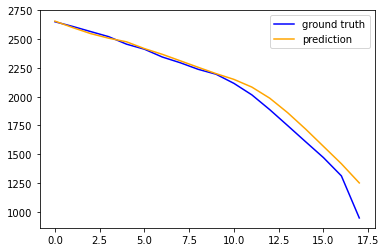

In [27]:
plt.plot(raw_value[-test_size:].values, color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.legend()
plt.ylim(top = 2750)
# plt.show()
plt.savefig("AR_demo.png", dpi=600)

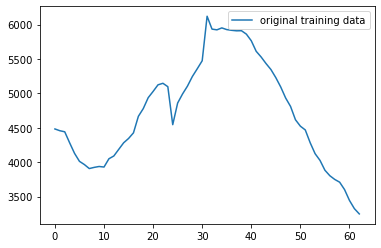

In [28]:
original_train = raw_value[:train_size]
x = range(0,len(original_train))
plt.plot(x,original_train, label = "original training data")
plt.legend()
plt.show()

Notice: absence of a periodic trend. As a result, including more data does not always give us a better result
- how does the algorithm work on different training and testing sets, given the same size of each?

# Evaluate AR Method on All Counties

In [29]:
diff = 1
RMSE = []
MAE = []
MAPE = []
trainingTime = []
for county in counties:
    s = extract(df1, county)
    raw_value = s[-(train_size+test_size+n_lag):]
    scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
    tic = time.perf_counter()
    model = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
    model = model.fit()
    toc = time.perf_counter()
    # make predictions
    predictions = make_forecasts(model, raw_value, test, test_size, n_lag, n_seq, diff)
    # compare and evaluate
    rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], predictions)
    RMSE.append(rmse)
    MAE.append(mae)
    MAPE.append(mape)
    trainingTime.append(toc-tic)

In [30]:
# mape counted in %
AR_evaluate = {'county': counties, 'rmse': RMSE, 'mae': MAE, 'mape': MAPE, "training time": trainingTime}
AR_evaluate = pd.DataFrame(AR_evaluate)
AR_evaluate

,county,rmse,mae,mape,training time
0,Los Angeles,93.059260,59.252688,4.221230,0.138752
1,San Diego,26.829189,16.290531,3.748680,0.122783
2,San Francisco,6.393149,5.119430,5.251342,0.136453
3,Santa Barbara,4.719182,3.346302,4.730895,0.095491
4,Fresno,8.686648,5.422573,3.475220,0.102727
5,Sacramento,14.178774,9.026248,4.684605,0.168285
6,Ventura,7.403845,5.029056,4.143153,0.138060
7,Riverside,23.652928,18.045714,4.752057,0.181892
